In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
# for the progress bar
from tqdm.auto import tqdm

- [`pandas` Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
- [`matplotlib` Cheat Sheet](https://matplotlib.org/cheatsheets/_images/cheatsheets-1.png)
- [SQL Cheat Sheet](https://www.sqltutorial.org/sql-cheat-sheet/)

# Loading the data

In [ ]:
df = pd.read_csv('https://drive.switch.ch/index.php/s/UEpTFv2Bfa5C1dd/download')
df.head()

This week we keep the `NaN` values.

In [ ]:
# df = df.dropna()

In [ ]:
feature_columns = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
missing_positions = df[df['position'].isna()]

# drop all rows with missing features
missing_positions = missing_positions.dropna(subset=feature_columns)

# vectorize the features
missing_positions_vec = missing_positions[feature_columns].values

missing_positions_vec

In [ ]:
# calculate vector for each position
positions = df[~df['position'].isna()]['position'].unique()
position_vectors = {}
for position in positions:
    position_players = df[df['position'] == position]
    position_players = position_players.dropna()  # drop those with missing values
    
    # vectorize
    position_vector = position_players[feature_columns].values
    
    # calculate average vector
    position_vectors[position] = position_vector.mean(axis=0)

# Task 1 - Forward / Backward selection

In [ ]:
feature_columns = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']

In [ ]:
def cosine_similarity(
        a: np.array, 
        b: np.array
) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
def position_vectors4features(
        features,
        player_df
):
    # calculate vector for each position
    positions = player_df[~player_df['position'].isna()]['position'].unique()
    position_vectors = {}
    for position in positions:
        position_players = player_df[player_df['position'] == position]
        position_players = position_players.dropna()  # drop those with missing values
        
        # vectorize
        position_vector = position_players[features].values
        
        # calculate average vector
        position_vectors[position] = position_vector.mean(axis=0)
    return position_vectors

In [ ]:
def estimate_player_position(
        player_vectors: np.array,
        position_vectors: np.array
) -> list[str]:
    estimated_positions = []
    for player_vec in player_vectors:
        sims = []
        for position, position_vector in position_vectors.items():
            # calculate cosine similarity
            similarity = cosine_similarity(a=player_vec, b=position_vector)
            sims.append((position, similarity))
        # sort by similarity
        sims = sorted(sims, key=lambda x: x[1], reverse=True)
        # take the most similar position
        estimated_positions.append((sims[0][0]))
    return estimated_positions

missing_estimates = estimate_player_position(missing_positions_vec, position_vectors)

In [ ]:
non_missing = df[~df['position'].isna()]
non_missing_vecs = non_missing[feature_columns].values

# calculate the estimated positions, for the non_missing players
estimated_positions = estimate_player_position(non_missing_vecs, position_vectors)

correct = (non_missing['position'] == estimated_positions).sum()
wrong = (non_missing['position'] != estimated_positions).sum()

print('Correct ratio:', correct / (correct + wrong))

In [ ]:
# compare with random guessing
random_positions = np.random.choice(positions, size=len(non_missing))
correct_random = (non_missing['position'] == random_positions).sum()
wrong_random = (non_missing['position'] != random_positions).sum()

print('Correct ratio (random):', correct_random / (correct_random + wrong_random))

In [ ]:
def evaluate_position_estimation(
        features,
        player_df
):
    non_missing = player_df[~player_df['position'].isna()]
    non_missing_vecs = non_missing[features].values
    
    positionvecs4features = position_vectors4features(
        features,
        player_df
    )
    
    # calculate the estimated positions, for the non_missing players
    estimated_positions = estimate_player_position(non_missing_vecs, positionvecs4features)
    
    correct = (non_missing['position'] == estimated_positions).sum()
    wrong = (non_missing['position'] != estimated_positions).sum()
    
    # print('Correct ratio:', correct / (correct + wrong))
    return correct / (correct + wrong)
    
evaluate_position_estimation(feature_columns, df)

In [ ]:
from typing import Optional


def forward_selection(
        max_features: int,
        player_df,
        selected_features: Optional[list[str]],
):
    feature2score = {}
    for feature in feature_columns:
        if feature in selected_features:
            continue
        current_features = selected_features + [feature]
        score = evaluate_position_estimation(
            current_features,
            player_df=player_df
        )
        feature2score[feature] = score
    # get best feature from score
    scores = sorted(feature2score.items(), key=lambda k: k[1], reverse=True)
    best_feature = scores[0][0]
    print(f'Adding feature: {best_feature} with score {scores[0][1]:4f}')
    if max_features > 0:
        return forward_selection(max_features - 1, player_df, selected_features + [best_feature])
    return selected_features

In [ ]:
def backward_selection(
        max_features: int,
        player_df,
        selected_features: Optional[list[str]],
):
    feature2score = {}
    for feature in feature_columns:
        if feature not in selected_features:
            continue
        current_features = selected_features.copy()
        current_features.remove(feature)
        score = evaluate_position_estimation(
            current_features,
            player_df=player_df
        )
        feature2score[feature] = score
    # get best feature from score
    scores = sorted(feature2score.items(), key=lambda k: k[1], reverse=True)
    worst_feature = scores[0][0]
    selected_features.remove(worst_feature)
    print(f'Removing feature: {worst_feature} with score {scores[0][1]:4f}')
    if len(selected_features) > max_features:
        return backward_selection(max_features, player_df, selected_features)
    return selected_features

In [ ]:
# start with no features, go up to 3
r = forward_selection(5, df, [])
r

In [ ]:
# start with no features, go up to 3
r = backward_selection(5, df, feature_columns.copy())
r

In [ ]:
score = evaluate_position_estimation(feature_columns, df)
score

# Task 2 - Normalization
Normalize all values in the `feature_columns` to be between 0 and 1.

# Task 3 - Binarization
Binarize all values in the `leagueCountry` column. Add a column for each possible value, and set it to 1 if the value is present, and 0 otherwise.

# Task 4 - PCA

Use PCA to reduce the number of features to 2. Then, use the 2 features to estimate the position of the players.

# Motivation: PCA and Word Vectors


In [26]:
!pip install gensim

In [27]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100")  # this will download and load the model

In [28]:
model["bread"]

array([-0.66146  ,  0.94335  , -0.72214  ,  0.17403  , -0.42524  ,
        0.36303  ,  1.0135   , -0.14802  ,  0.25817  , -0.20326  ,
       -0.64338  ,  0.16632  ,  0.61518  ,  1.397    , -0.094506 ,
        0.0041843, -0.18976  , -0.55421  , -0.39371  , -0.22501  ,
       -0.34643  ,  0.32076  ,  0.34395  , -0.7034   ,  0.23932  ,
        0.69951  , -0.16461  , -0.31819  , -0.34034  , -0.44906  ,
       -0.069667 ,  0.35348  ,  0.17498  , -0.95057  , -0.2209   ,
        1.0647   ,  0.23231  ,  0.32569  ,  0.47662  , -1.1206   ,
        0.28168  , -0.75172  , -0.54654  , -0.66337  ,  0.34804  ,
       -0.69058  , -0.77092  , -0.40167  , -0.069351 , -0.049238 ,
       -0.39351  ,  0.16735  , -0.14512  ,  1.0083   , -1.0608   ,
       -0.87314  , -0.29339  ,  0.68278  ,  0.61634  , -0.088844 ,
        0.88094  ,  0.099809 , -0.27161  , -0.58026  ,  0.50364  ,
       -0.93814  ,  0.67576  , -0.43124  , -0.10517  , -1.2404   ,
       -0.74353  ,  0.28637  ,  0.29012  ,  0.89377  ,  0.6740

In [29]:
model.most_similar("bread")

[('flour', 0.7654520869255066),
 ('baked', 0.7607272863388062),
 ('cake', 0.7605516910552979),
 ('loaf', 0.7457114458084106),
 ('toast', 0.7397798895835876),
 ('cheese', 0.7374635338783264),
 ('potato', 0.7367483973503113),
 ('butter', 0.7279618978500366),
 ('potatoes', 0.7085272669792175),
 ('pasta', 0.7071876525878906)]

In [30]:
model.most_similar(negative="bread")

[('amisha', 0.47772663831710815),
 ('davalos', 0.4771687090396881),
 ('shunichi', 0.46397554874420166),
 ('yujiro', 0.45155149698257446),
 ('s-class', 0.4454616904258728),
 ('narsad', 0.44458815455436707),
 ('losi', 0.4423774778842926),
 ('katsuhisa', 0.44220131635665894),
 ('american-arab', 0.440533846616745),
 ('faliero', 0.4377879798412323)]

In [31]:
word, sim = model.most_similar(positive=["woman", "king"], negative=["man"])[0]
print(f"{word}: {sim:.4f}")

queen: 0.7699


In [32]:
def analogy(x1, x2, y1):
    word, _ = model.most_similar(positive=[y1, x2], negative=[x1])[0]
    return word

In [33]:
analogy("japan", "japanese", "switzerland")

'swiss'

In [34]:
analogy("switzerland", "cheese", "germany")

'sausage'

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [36]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
        else:
            words = [word for word in model.index_to_key]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]

    plt.figure(figsize=(12, 12))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors="k", c="r")
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)
    plt.show()

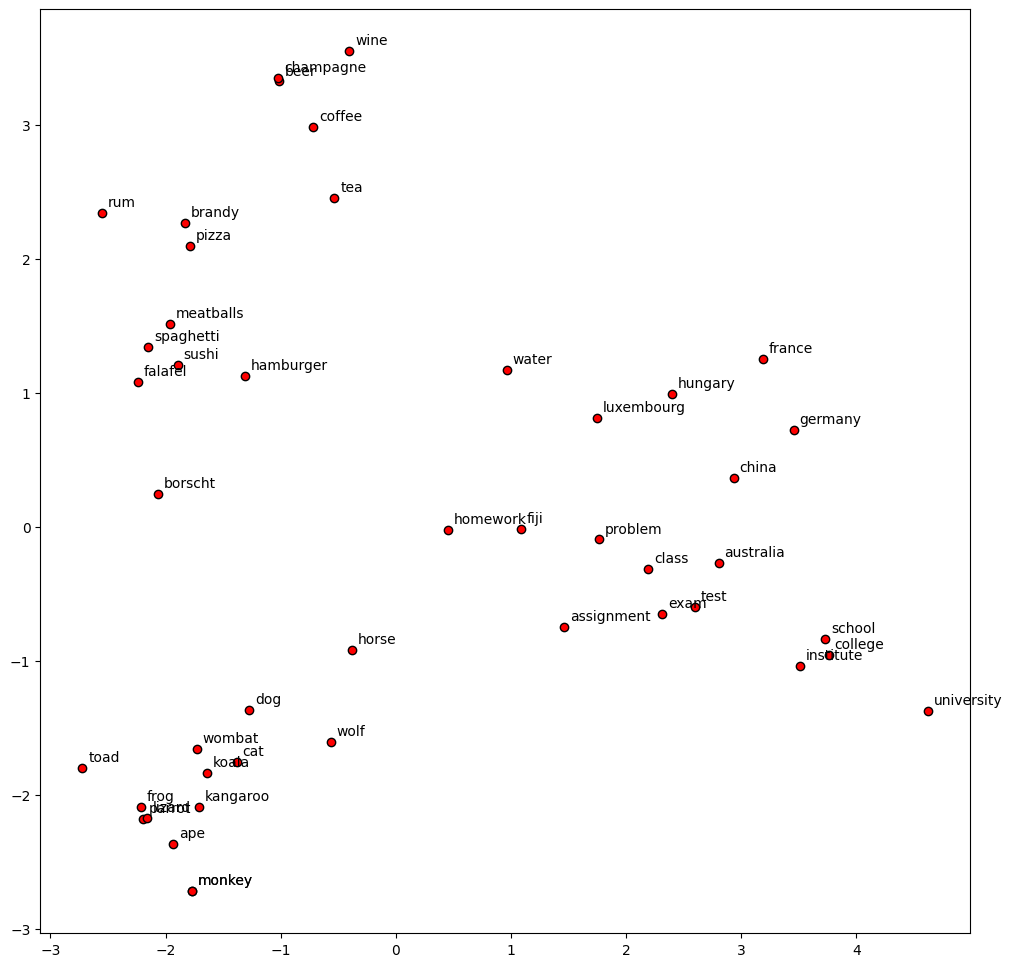

In [37]:
display_pca_scatterplot(
    model,
    [
        "coffee",
        "tea",
        "beer",
        "wine",
        "brandy",
        "rum",
        "champagne",
        "water",
        "spaghetti",
        "borscht",
        "hamburger",
        "pizza",
        "falafel",
        "sushi",
        "meatballs",
        "dog",
        "horse",
        "cat",
        "monkey",
        "parrot",
        "koala",
        "lizard",
        "frog",
        "toad",
        "monkey",
        "ape",
        "kangaroo",
        "wombat",
        "wolf",
        "france",
        "germany",
        "hungary",
        "luxembourg",
        "australia",
        "fiji",
        "china",
        "homework",
        "assignment",
        "problem",
        "exam",
        "test",
        "class",
        "school",
        "college",
        "university",
        "institute",
    ],
)